In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [21]:
from utils import *
from word_network import WordNetwork

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.stats import entropy as calculate_entropy

from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### load dataset

In [22]:
# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.religion.misc', 'comp.graphics', 'sci.space']

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

### clean dataset

In [23]:
datasize = 500
max_document_length = 256

index = -1
clean_docs = []
with tqdm(total=datasize) as pbar:
    while index < len(docs)-1 and len(clean_docs) != datasize:
        index += 1
        doc = docs[index]

        status, doc, word_count = clean_doc(doc)
        if (not status) or (max_document_length is not None and len(doc) > max_document_length):
            continue

        clean_docs.append(doc)
        pbar.update(1)

print(clean_docs[0])


apparently you re not a woman my husband hate the auto door lock feel safer in a car that lock easily in addition to watching around in a secluded spot etc have my key ready to open the door so i m


In [24]:
print(f"there are {len(clean_docs)} docs")

there are 500 docs


### count words

In [25]:
mode = "tfidf"
# mode = "binary"
# mode = "normalize"
# mode = "binary-normalize"

# initialize the count vectorizer
vectorizer = TfidfVectorizer() if mode == "tfidf" else CountVectorizer()

# fit it to dataset
train_docs, test_docs = train_test_split(clean_docs, test_size=.33, random_state=42)

vectorizer.fit(train_docs)
vocabulary = vectorizer.get_feature_names()

print("word_count is", len(vocabulary))

word_count is 2695


### Prepare Datatset

In [26]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(train_docs).toarray()
test_doc_vectors = vectorizer.transform(test_docs).toarray()

if mode == "binary-normalize" or mode == "binary":
    train_doc_vectors = (train_doc_vectors > 0).astype(float)
    test_doc_vectors = (test_doc_vectors > 0).astype(float)
    
if mode == "normalize" or mode == "binary-normalize":
    train_doc_vectors = normalize(train_doc_vectors, norm="l1", axis=1)
    test_doc_vectors = normalize(test_doc_vectors, norm="l1", axis=1)

print(f"{len(train_doc_vectors)} train_docs, {len(test_doc_vectors)} test docs")

335 train_docs, 165 test docs


### Word-Word Ratio

In [27]:
#reduce freq in doc to bin value of 1 or 0
word_doc_freqency = pd.DataFrame(train_doc_vectors, columns=vocabulary)

#the sum vertically of bin freq
word_doc_total_frequency = word_doc_freqency.sum(0)

word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)
# all_docs_trust_factor = sigmoid((word_doc_freqency > 0).sum(0))
word_frequency_norm = ((word_doc_freqency > 0).sum(0) / len(train_doc_vectors))

for word in tqdm(vocabulary):
    word_word_frequency = word_doc_freqency[word_doc_freqency[word] > 0].sum(0)
    word_word_co[word] = ((word_word_frequency * word_frequency_norm) / word_doc_total_frequency).fillna(0)

print(f"word_word_co has shape {word_word_co.shape}")


word_word_co has shape (2695, 2695)


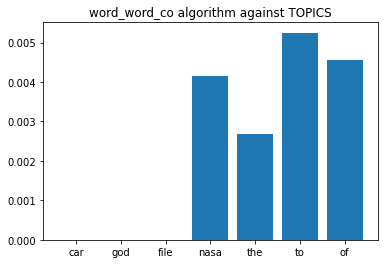

In [28]:
word = "algorithm"
words = ["car", "god", "file", "nasa", "the", "to", "of"]

plt.title(f"word_word_co {word} against TOPICS")
plt.bar(words, word_word_co.loc[word][words])

plt.show()

In [31]:
word_trust_factor = gaussian2((np.nan_to_num(calculate_entropy(word_word_co.T, base=2)))) + (0 * word_frequency_norm)
wwc = (word_word_co * word_trust_factor)

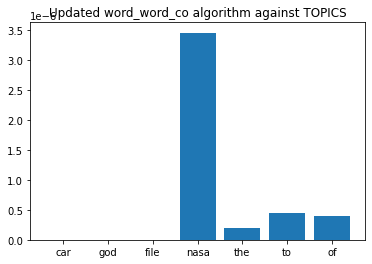

In [32]:
words = ["car", "god", "file", "nasa", "the", "to", "of"]

plt.title(f"Updated word_word_co {word} against TOPICS")
plt.bar(words, wwc.loc[word][words])

plt.show()

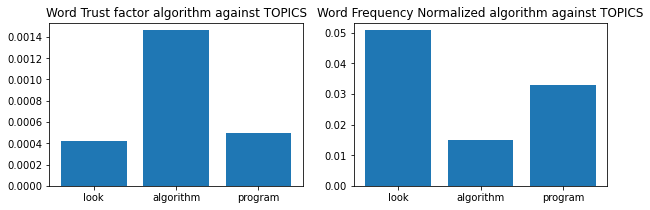

In [33]:
words = ["look", "algorithm", "program"]
# words = ["looking", "algorithm", "program", "the", "to", "of"]

fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title(f"Word Trust factor {word} against TOPICS")
ax1.bar(words, word_trust_factor[words])

ax2.set_title(f"Word Frequency Normalized {word} against TOPICS")
ax2.bar(words, word_frequency_norm[words])

plt.show()

In [38]:
word = "algorithm"
word_word_co.loc[word].sort_values(ascending=False).head(5)

algorithm    0.014925
for          0.013055
and          0.013055
is           0.009675
an           0.008857
Name: algorithm, dtype: float64

In [39]:
wwc.loc[word].sort_values(ascending=False).head(5)

method         0.000042
shading        0.000042
calculating    0.000027
detecting      0.000027
cusp           0.000027
Name: algorithm, dtype: float64

In [64]:
word_word_co.head()

,00,000,0098,01,01a,077,0878,0a,0x100,10,...,yellow,yep,yes,yet,yo,you,your,yourself,zaphod,zip
00,0.000355,0.000032,0.000000e+00,0.000034,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000346,...,0.000000,0.0,0.00000,0.000136,0.0,2.159443e-06,9.694003e-07,9.960444e-08,0.0,7.014640e-06
000,0.000031,0.000513,0.000000e+00,0.000051,0.000000e+00,0.0,0.0,0.0,2.675231e-07,0.000598,...,0.000001,0.0,0.00005,0.000237,0.0,4.012108e-06,2.553071e-06,3.647042e-06,0.0,8.597910e-07
0098,0.000000,0.000000,2.336033e-07,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,...,0.000000,0.0,0.00000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
01,0.000111,0.000012,0.000000e+00,0.000146,7.074505e-07,0.0,0.0,0.0,0.000000e+00,0.000147,...,0.000001,0.0,0.00000,0.000022,0.0,1.369328e-06,3.484819e-07,5.828098e-08,0.0,1.539303e-07
01a,0.000000,0.000000,0.000000e+00,0.000006,2.336033e-07,0.0,0.0,0.0,0.000000e+00,0.000000,...,0.000000,0.0,0.00000,0.000000,0.0,1.146207e-07,0.000000e+00,0.000000e+00,0.0,0.000000e+00


### Evaluate Topic model with Train set

In [65]:
score = 0
misclassified_train = []
print("Evaluating Topic Model...")

for doc_index in tqdm(range(len(train_labels))):
    doc_vector = train_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[train_labels[doc_index]])
    
    if doc_topic != label_classes[train_labels[doc_index]]:
        misclassified_train.append(doc_index)
    
train_accuracy = score / (doc_index + 1)
print(f"==> train-accuracy is {train_accuracy*100:.2f}%, {len(misclassified_train)} misclassified\n")

Evaluating Topic Model...



==> train-accuracy is 90.67%, 25 misclassified



### Evaluating Topic Model with test set

In [66]:
score = 0
print("Evaluating Topic Model...")

misclassified_test = []
for doc_index in tqdm(range(len(test_labels))):
    doc_vector = test_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[test_labels[doc_index]])
    
    if doc_topic != label_classes[test_labels[doc_index]]:
        misclassified_test.append(doc_index)
    

test_accuracy = score / (doc_index + 1)
print(f"==> test-accuracy is {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%, {len(misclassified_test)} misclassified\n")

Evaluating Topic Model...



==> test-accuracy is 54.55%, avg-accuarcy = 72.61%, 60 misclassified



### Investigating Misclassification

In [89]:
training = True
tlabels = train_labels if training else test_labels
tdoc_vectors = train_doc_vectors if training else test_doc_vectors
misclassified = misclassified_train if training else misclassified_test

for doc_index in tqdm(misclassified):
    doc_vector = tdoc_vectors[doc_index]
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    
    xv = doc_topic_word_distr.iloc[np.where(doc_topic_word_distr.sum(1) > 0)]
    print(xv.loc[xv.sum(1).sort_values(ascending=False).index])
    print(train_docs[doc_index])
    print(f"==> predicted_topic = {doc_topic}, actual_topic = {label_classes[tlabels[doc_index]]} \n")
#     break

              autos  religion  graphics     space
ve         0.000334  0.000191  0.001622  0.000000
sense      0.000426  0.001182  0.000000  0.000000
maybe      0.000000  0.000906  0.000605  0.000000
shot       0.000000  0.000677  0.000000  0.000371
that       0.000299  0.000251  0.000241  0.000251
kind       0.000000  0.000394  0.000588  0.000000
cheap      0.000000  0.000954  0.000000  0.000000
embarrass  0.000000  0.000954  0.000000  0.000000
fundies    0.000000  0.000954  0.000000  0.000000
josh       0.000000  0.000954  0.000000  0.000000
mood       0.000000  0.000954  0.000000  0.000000
mcdowell   0.000000  0.000954  0.000000  0.000000
be         0.000165  0.000224  0.000176  0.000203
of         0.000119  0.000248  0.000176  0.000181
to         0.000140  0.000208  0.000155  0.000176
okay       0.000000  0.000375  0.000293  0.000000
except     0.000307  0.000350  0.000000  0.000000
who        0.000148  0.000316  0.000030  0.000111
but        0.000055  0.000224  0.000197  0.000128


may       0.000021  0.000090  0.000056  0.000031
from phil g fraering pgf srl03 cacs usl edu right the profit caste be bless by god and may freely blare it presence in the even twilight
==> predicted_topic = religion, actual_topic = space 

            autos  religion  graphics     space
help     0.000000  0.000315  0.001873  0.000330
the      0.000425  0.000436  0.000395  0.000502
rest     0.000000  0.000886  0.000000  0.000424
shirt    0.000000  0.001130  0.000000  0.000000
night    0.000000  0.001130  0.000000  0.000000
delete   0.000000  0.001130  0.000000  0.000000
brown    0.000000  0.001130  0.000000  0.000000
of       0.000141  0.000293  0.000209  0.000215
out      0.000276  0.000259  0.000199  0.000120
in       0.000158  0.000150  0.000188  0.000167
can      0.000104  0.000085  0.000193  0.000155
about    0.000169  0.000113  0.000081  0.000073
anybody  0.000088  0.000057  0.000209  0.000041
find     0.000124  0.000046  0.000141  0.000030
rest delete can anybody out in a p h he

### Using Latent Dirichlet Allocation

In [68]:
clf = MultinomialNB(alpha=.01)
clf.fit(train_doc_vectors, train_labels)

train_accuracy = clf.score(train_doc_vectors, train_labels)
test_accuracy = clf.score(test_doc_vectors, test_labels)

print(f"training_accuarcy = {train_accuracy*100:.2f}%, test_accuarcy = {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%")

training_accuarcy = 100.00%, test_accuarcy = 62.88%, avg-accuarcy = 81.44%
